# ***DermAssist***

### ***Imports***

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from collections import Counter

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### ***Setting up the Path***

In [3]:
PROJECT_ROOT = r"D:\Projects JP\DermAssist"
DATASET_ROOT = os.path.join(PROJECT_ROOT, "Dataset")
MODEL_ROOT = r"D:\Projects JP\DermAssist\Models"

IMAGES_DIR_1 = os.path.join(DATASET_ROOT, "HAM10000_images_part_1")
IMAGES_DIR_2 = os.path.join(DATASET_ROOT, "HAM10000_images_part_2")
METADATA_PATH = os.path.join(DATASET_ROOT, "HAM10000_metadata.csv")

os.makedirs(MODEL_ROOT, exist_ok=True)

### ***EDA***

In [4]:
df = pd.read_csv(METADATA_PATH)

print("Total samples:", len(df))
df.head()

Total samples: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [6]:
df["dx"].value_counts(normalize=True) * 100

dx
nv       66.949576
mel      11.113330
bkl      10.973540
bcc       5.132302
akiec     3.265102
vasc      1.417873
df        1.148278
Name: proportion, dtype: float64

In [7]:
df["lesion_id"].nunique()

7470

In [8]:
df = pd.read_csv(METADATA_PATH)

print("Total Samples:", len(df))
print(df['dx'].value_counts())

Total Samples: 10015
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [9]:
df.groupby("lesion_id").size().describe()

count    7470.000000
mean        1.340696
std         0.633970
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
dtype: float64

In [10]:
malignant_classes = ["mel", "bcc", "akiec"]

df["binary_label"] = df["dx"].apply(
    lambda x: "malignant" if x in malignant_classes else "benign"
)

df["label"] = df["binary_label"].map({
    "benign": 0,
    "malignant": 1
})

print(df["binary_label"].value_counts())

binary_label
benign       8061
malignant    1954
Name: count, dtype: int64


In [11]:
df.groupby("lesion_id")["dx"].nunique().value_counts()

dx
1    7470
Name: count, dtype: int64

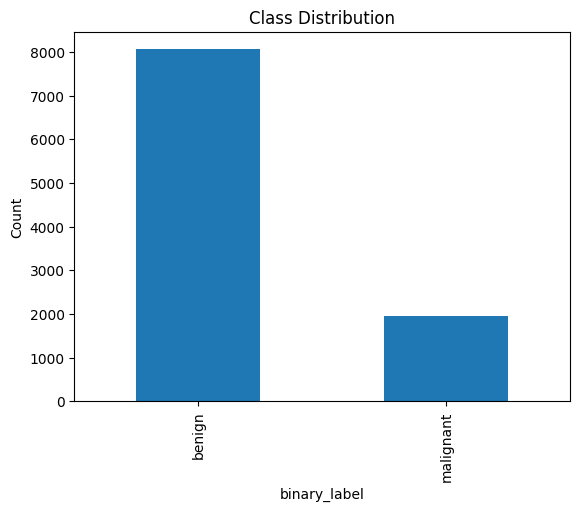

In [12]:
df['binary_label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()

### ***Data Prepration***

In [13]:
image_paths = {}

for folder in [IMAGES_DIR_1, IMAGES_DIR_2]:
    for fname in os.listdir(folder):
        image_id = fname.split(".")[0]
        image_paths[image_id] = os.path.join(folder, fname)

df['image_path'] = df['image_id'].map(image_paths)

print("Missing images:", df['image_path'].isnull().sum())

Missing images: 0


In [14]:
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

train_idx, val_idx = next(
    gss.split(df, groups=df['lesion_id'])
)

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)

print("Train distribution:")
print(train_df['binary_label'].value_counts())

print("\nValidation distribution:")
print(val_df['binary_label'].value_counts())

Train distribution:
binary_label
benign       6430
malignant    1561
Name: count, dtype: int64

Validation distribution:
binary_label
benign       1631
malignant     393
Name: count, dtype: int64


### ***Data Preprocessing***

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [16]:
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        label = row["label"]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

### ***Training Setup & Model Initialization***

In [17]:
BATCH_SIZE = 32

train_dataset = HAM10000Dataset(train_df, transform=train_transform)
val_dataset = HAM10000Dataset(val_df, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))

Train batches: 250
Validation batches: 64


In [18]:
counter = Counter(train_df["label"])

num_neg = counter[0]
num_pos = counter[1]

pos_weight = torch.tensor([num_neg / num_pos]).to(device)

print("Negative samples:", num_neg)
print("Positive samples:", num_pos)
print("Computed pos_weight:", pos_weight.item())

Negative samples: 6430
Positive samples: 1561
Computed pos_weight: 4.119154453277588


In [19]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

### ***Model Architecture***

In [29]:
def build_model():
    model = models.resnet50(weights="IMAGENET1K_V1")
    
    in_features = model.fc.in_features
    
    model.fc = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256, 1)
    )
    
    return model.to(device)

In [30]:
def build_optimizer(model):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-4
    )
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=20
    )
    
    return optimizer, scheduler

In [22]:
def train_one_epoch(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [23]:
def validate_model(model, val_loader):
    model.eval()
    total_loss = 0
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    val_loss = total_loss / len(val_loader)
    val_auc = roc_auc_score(all_labels, all_probs)
    
    return val_loss, val_auc

### ***Model Training***

In [24]:
def train_model(model, train_loader, val_loader, save_path,
                num_epochs=20, patience=4):
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-4
    )
    
    best_auc = 0
    counter = 0
    
    for epoch in range(num_epochs):
        
        train_loss = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_auc = validate_model(model, val_loader)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss:   {val_loss:.4f}")
        print(f"Val AUC:    {val_auc:.4f}")
        
        if val_auc > best_auc:
            best_auc = val_auc
            counter = 0
            torch.save(model.state_dict(), save_path)
            print("Best model saved")
        else:
            counter += 1
        
        if counter >= patience:
            print("Early stopping triggered")
            break
    
    print("Best Validation AUC:", best_auc)

In [25]:
print("Training Model 1")

model1 = build_model()
save_path1 = os.path.join(MODEL_ROOT, "resnet50_model_1.pth")

train_model(model1, train_loader, val_loader, save_path1)

Training Model 1

Epoch [1/20]
Train Loss: 0.6917
Val Loss:   0.6723
Val AUC:    0.8910
Best model saved

Epoch [2/20]
Train Loss: 0.5674
Val Loss:   0.6845
Val AUC:    0.8943
Best model saved

Epoch [3/20]
Train Loss: 0.4950
Val Loss:   0.6009
Val AUC:    0.9246
Best model saved

Epoch [4/20]
Train Loss: 0.4426
Val Loss:   0.6217
Val AUC:    0.9193

Epoch [5/20]
Train Loss: 0.4064
Val Loss:   0.7043
Val AUC:    0.9073

Epoch [6/20]
Train Loss: 0.3575
Val Loss:   0.7803
Val AUC:    0.9003

Epoch [7/20]
Train Loss: 0.2932
Val Loss:   0.7623
Val AUC:    0.9168
Early stopping triggered
Best Validation AUC: 0.924636066791163


In [27]:
print("Training Model 2")

model2 = build_model()
save_path2 = os.path.join(MODEL_ROOT, "resnet50_model_2.pth")

train_model(model2, train_loader, val_loader, save_path2)

Training Model 2

Epoch [1/20]
Train Loss: 0.6839
Val Loss:   0.6365
Val AUC:    0.9050
Best model saved

Epoch [2/20]
Train Loss: 0.5636
Val Loss:   0.6453
Val AUC:    0.9092
Best model saved

Epoch [3/20]
Train Loss: 0.5213
Val Loss:   0.6060
Val AUC:    0.9230
Best model saved

Epoch [4/20]
Train Loss: 0.4548
Val Loss:   0.6815
Val AUC:    0.9054

Epoch [5/20]
Train Loss: 0.4233
Val Loss:   0.6604
Val AUC:    0.9123

Epoch [6/20]
Train Loss: 0.3692
Val Loss:   0.6168
Val AUC:    0.9203

Epoch [7/20]
Train Loss: 0.3316
Val Loss:   0.6519
Val AUC:    0.9240
Best model saved

Epoch [8/20]
Train Loss: 0.2918
Val Loss:   0.6701
Val AUC:    0.9263
Best model saved

Epoch [9/20]
Train Loss: 0.2546
Val Loss:   0.9416
Val AUC:    0.9176

Epoch [10/20]
Train Loss: 0.2317
Val Loss:   0.8110
Val AUC:    0.9191

Epoch [11/20]
Train Loss: 0.2189
Val Loss:   1.1157
Val AUC:    0.9189

Epoch [12/20]
Train Loss: 0.1935
Val Loss:   0.9385
Val AUC:    0.9153
Early stopping triggered
Best Validation AU

In [28]:
print("Training Model 3")

model3 = build_model()
save_path3 = os.path.join(MODEL_ROOT, "resnet50_model_3.pth")

train_model(model3, train_loader, val_loader, save_path3)

Training Model 3

Epoch [1/20]
Train Loss: 0.6898
Val Loss:   0.6460
Val AUC:    0.9027
Best model saved

Epoch [2/20]
Train Loss: 0.5677
Val Loss:   0.7155
Val AUC:    0.8964

Epoch [3/20]
Train Loss: 0.5174
Val Loss:   0.7733
Val AUC:    0.9032
Best model saved

Epoch [4/20]
Train Loss: 0.4626
Val Loss:   0.7271
Val AUC:    0.8933

Epoch [5/20]
Train Loss: 0.4174
Val Loss:   0.6383
Val AUC:    0.9245
Best model saved

Epoch [6/20]
Train Loss: 0.3641
Val Loss:   0.6114
Val AUC:    0.9198

Epoch [7/20]
Train Loss: 0.3164
Val Loss:   0.7985
Val AUC:    0.9071

Epoch [8/20]
Train Loss: 0.2848
Val Loss:   0.7747
Val AUC:    0.9140

Epoch [9/20]
Train Loss: 0.2612
Val Loss:   0.7442
Val AUC:    0.9147
Early stopping triggered
Best Validation AUC: 0.9244894170360212


### ***Loading Model + Ensemble Inference***

In [4]:
def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

model1 = load_model(os.path.join(MODEL_ROOT, "resnet50_model_1.pth"))
model2 = load_model(os.path.join(MODEL_ROOT, "resnet50_model_2.pth"))
model3 = load_model(os.path.join(MODEL_ROOT, "resnet50_model_3.pth"))

ensemble_models = [model1, model2, model3]

print("All models loaded successfully.")

All models loaded successfully.


In [ ]:
all_labels = []
all_model_probs = []

for model in ensemble_models:
    model_probs = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            
            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs)
            
            model_probs.extend(probs.cpu().numpy())
            
            if len(all_labels) < len(val_loader.dataset):
                all_labels.extend(labels.numpy())
    
    all_model_probs.append(model_probs)

all_model_probs = np.array(all_model_probs)   
all_labels = np.array(all_labels)

mean_probs = np.mean(all_model_probs, axis=0)
std_probs = np.std(all_model_probs, axis=0)

print("Ensemble predictions generated.")

Ensemble predictions generated.


### ***Ensemble Evaluation & Metrics***

In [21]:
ensemble_auc = roc_auc_score(all_labels, mean_probs)
print("Ensemble AUC:", ensemble_auc)

Ensemble AUC: 0.9370560529686436


In [22]:
CLASSIFICATION_THRESHOLD = 0.35

ensemble_preds = (mean_probs >= CLASSIFICATION_THRESHOLD).astype(int)

cm = confusion_matrix(all_labels, ensemble_preds)
print("Confusion Matrix (Threshold = 0.5):")
print(cm)

print("\nClassification Report:")
print(classification_report(all_labels, ensemble_preds, target_names=["Benign", "Malignant"]))

Confusion Matrix (Threshold = 0.5):
[[1288  343]
 [  28  365]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.79      0.87      1631
   Malignant       0.52      0.93      0.66       393

    accuracy                           0.82      2024
   macro avg       0.75      0.86      0.77      2024
weighted avg       0.89      0.82      0.83      2024



In [ ]:
tp_mask = (ensemble_preds == 1) & (all_labels == 1)
tn_mask = (ensemble_preds == 0) & (all_labels == 0)
fp_mask = (ensemble_preds == 1) & (all_labels == 0)
fn_mask = (ensemble_preds == 0) & (all_labels == 1)

print("Mean Uncertainty:")
print("TP:", np.mean(std_probs[tp_mask]))
print("TN:", np.mean(std_probs[tn_mask]))
print("FP:", np.mean(std_probs[fp_mask]))
print("FN:", np.mean(std_probs[fn_mask]))

Mean Uncertainty:
TP: 0.1009575
TN: 0.055878036
FP: 0.1837501
FN: 0.15590739


### ***Uncertainity Based Filtering***

In [ ]:
UNCERTAINTY_THRESHOLD = 0.165

uncertain_mask = std_probs > UNCERTAINTY_THRESHOLD

print("Total Uncertain Flagged:", np.sum(uncertain_mask))

confident_preds = ensemble_preds[~uncertain_mask]
confident_labels = all_labels[~uncertain_mask]

cm_confident = confusion_matrix(confident_labels, confident_preds)

print("\nConfusion Matrix (Confident Only):")
print(cm_confident)

print("\nClassification Report (Confident Only):")
print(classification_report(confident_labels, confident_preds, target_names=["Benign", "Malignant"]))

original_fn = np.sum(fn_mask)
fn_flagged = np.sum(fn_mask & uncertain_mask)

print("\nOriginal FN:", original_fn)
print("FN flagged as Uncertain:", fn_flagged)

Total Uncertain Flagged: 477

Confusion Matrix (Confident Only):
[[1100  155]
 [  15  277]]

Classification Report (Confident Only):
              precision    recall  f1-score   support

      Benign       0.99      0.88      0.93      1255
   Malignant       0.64      0.95      0.77       292

    accuracy                           0.89      1547
   macro avg       0.81      0.91      0.85      1547
weighted avg       0.92      0.89      0.90      1547


Original FN: 28
FN flagged as Uncertain: 13


### ***Inference & Decision Logic***

In [25]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    return image

In [26]:
def ensemble_predict(models, image_tensor):
    probs = []
    
    with torch.no_grad():
        for model in models:
            output = model(image_tensor).squeeze()
            prob = torch.sigmoid(output).item()
            probs.append(prob)
    
    mean_prob = np.mean(probs)
    std_prob = np.std(probs)
    
    return mean_prob, std_prob, probs

In [27]:
CLASSIFICATION_THRESHOLD = 0.5
UNCERTAINTY_THRESHOLD = 0.165

def decision_logic(mean_prob, std_prob):
    
    if std_prob > UNCERTAINTY_THRESHOLD:
        return "Uncertain – Professional Review Recommended"
    
    if mean_prob >= 0.75:
        return "High Risk – Immediate Dermatology Consultation Recommended"
    
    if mean_prob >= CLASSIFICATION_THRESHOLD:
        return "Moderate Risk – Professional Evaluation Recommended"
    
    return "Low Risk – Monitor and Recheck"

### ***GradCam Initialization***

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_image, target_class=1):
        self.model.zero_grad()
        
        output = self.model(input_image)
        
        if target_class == 1:
            loss = output
        else:
            loss = -output
        
        loss.backward()
        
        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam[cam < np.percentile(cam, 75)] = 0

        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam

In [ ]:
def show_gradcam_overlay(image_path, cam, alpha=0.4):
    
    original = cv2.imread(image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    original = cv2.resize(original, (224, 224))
    
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam),
        cv2.COLORMAP_JET
    )
    
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    overlay = cv2.addWeighted(original, 1 - alpha, heatmap, alpha, 0)
    
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,3,1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1,3,2)
    plt.imshow(cam, cmap="jet")
    plt.title("Heatmap")
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [30]:
target_layer = model1.layer4[-1]
gradcam = GradCAM(model1, target_layer)

### ***End-to-End Prediction with GradCam***

In [43]:
def dermassist_predict(image_path):
    
    image_tensor = preprocess_image(image_path, val_test_transform)
    
    image_tensor = image_tensor.to(device)
    
    mean_prob, std_prob, individual_probs = ensemble_predict(
        ensemble_models,
        image_tensor
    )
    
    decision = decision_logic(mean_prob, std_prob)
    
    target_class = 1 if mean_prob >= CLASSIFICATION_THRESHOLD else 0
    cam = gradcam.generate(image_tensor, target_class=target_class)
    
    confidence = 1 - std_prob
    
    return {
        "probability": float(mean_prob),
        "confidence": float(confidence),
        "uncertainty": float(std_prob),
        "decision": decision,
        "individual_model_probs": individual_probs,
        "gradcam": cam
    }

probability: 0.07467786781489849
confidence: 0.9351105020270899
uncertainty: 0.06488949797291015
decision: Low Risk – Monitor and Recheck
individual_model_probs: [0.16644494235515594, 0.029065335169434547, 0.02852332592010498]


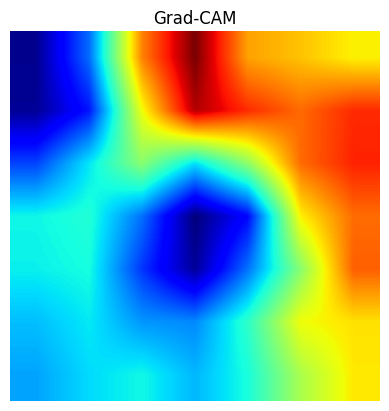

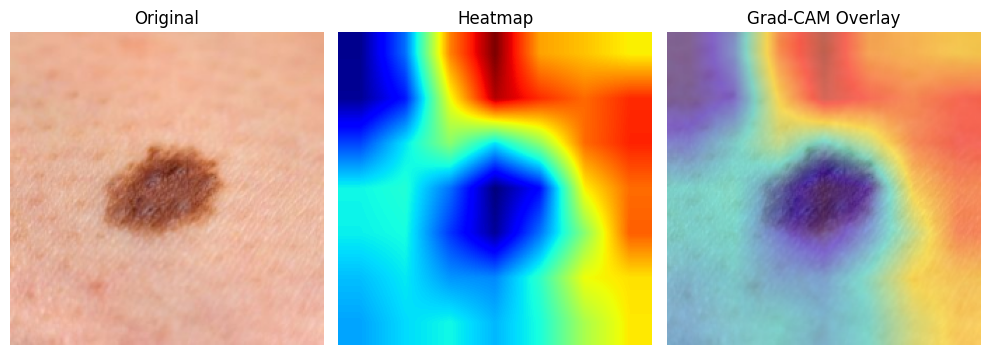

In [44]:
result = dermassist_predict("C:\\Users\\hp\\Downloads\\abcdes-of-melanoma-signs-of-skin-cancer-300x300.jpg")

for key, value in result.items():
    if key != "gradcam":
        print(f"{key}: {value}")

plt.imshow(result["gradcam"], cmap="jet")
plt.title("Grad-CAM")
plt.axis("off")
plt.show()

show_gradcam_overlay(
    "C:\\Users\\hp\\Downloads\\abcdes-of-melanoma-signs-of-skin-cancer-300x300.jpg",
    result["gradcam"],
    alpha=0.45
)

### ***Validating On ISIC 2019 Dataset***

In [20]:
import os
import pandas as pd

ISIC_2019_IMAGES = r"D:\Projects JP\DermAssist\Testing\ISIC_2019_Test_Input"
ISIC_2019_GT = r"D:\Projects JP\DermAssist\Testing\ISIC_2019_Test_GroundTruth.csv"

print("Images Path Exists:", os.path.exists(ISIC_2019_IMAGES))
print("Ground Truth Exists:", os.path.exists(ISIC_2019_GT))

Images Path Exists: True
Ground Truth Exists: True


In [21]:
gt_df = pd.read_csv(ISIC_2019_GT)

print(gt_df.head())
print(gt_df.columns)

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK  score_weight  \
0  ISIC_0034321  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   
1  ISIC_0034322  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   
2  ISIC_0034323  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   
3  ISIC_0034324  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   
4  ISIC_0034325  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0           0.0   

   validation_weight  
0                1.0  
1                1.0  
2                1.0  
3                1.0  
4                1.0  
Index(['image', 'MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK',
       'score_weight', 'validation_weight'],
      dtype='object')


In [22]:
class_cols = ["MEL","NV","BCC","AK","BKL","DF","VASC","SCC"]

# Convert one-hot columns to single diagnosis column
gt_df["dx"] = gt_df[class_cols].idxmax(axis=1).str.lower()

print(gt_df["dx"].value_counts())

dx
mel     3374
nv      2495
bcc      975
bkl      660
ak       374
scc      165
vasc     104
df        91
Name: count, dtype: int64


In [23]:
allowed_classes = ["mel","bcc","ak","nv","bkl","df","vasc"]

filtered_df = gt_df[gt_df["dx"].isin(allowed_classes)].copy()

print("Original size:", len(gt_df))
print("Filtered size:", len(filtered_df))
print(filtered_df["dx"].value_counts())

Original size: 8238
Filtered size: 8073
dx
mel     3374
nv      2495
bcc      975
bkl      660
ak       374
vasc     104
df        91
Name: count, dtype: int64


In [24]:
malignant_classes = ["mel","bcc","ak"]

filtered_df["label"] = filtered_df["dx"].apply(
    lambda x: 1 if x in malignant_classes else 0
)

print(filtered_df["label"].value_counts())

label
1    4723
0    3350
Name: count, dtype: int64


In [25]:
import os

ISIC_2019_TEST_DIR = r"D:\Projects JP\DermAssist\Testing\ISIC_2019_Test_Input"

filtered_df["image_path"] = filtered_df["image"].apply(
    lambda x: os.path.join(ISIC_2019_TEST_DIR, x + ".jpg")
)

# Verify paths exist
missing = filtered_df[~filtered_df["image_path"].apply(os.path.exists)]
print("Missing images:", len(missing))

Missing images: 0


In [26]:
class ISIC2019Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        label = row["label"]

        if self.transform:
            image = self.transform(image)

        return image, label

In [27]:
isic_dataset = ISIC2019Dataset(filtered_df, transform=val_test_transform)

isic_loader = DataLoader(
    isic_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

print("ISIC test batches:", len(isic_loader))

ISIC test batches: 253


In [31]:
model1 = build_model()
model1.load_state_dict(torch.load(os.path.join(MODEL_ROOT, "resnet50_model_1.pth")))
model1.eval()

model2 = build_model()
model2.load_state_dict(torch.load(os.path.join(MODEL_ROOT, "resnet50_model_2.pth")))
model2.eval()

model3 = build_model()
model3.load_state_dict(torch.load(os.path.join(MODEL_ROOT, "resnet50_model_3.pth")))
model3.eval()

ensemble_models = [model1, model2, model3]

print("Models loaded.")

Models loaded.


In [ ]:
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in isic_loader:
        images = images.to(device)

        batch_probs = []

        for model in ensemble_models:
            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()
            batch_probs.append(probs)
            
        batch_probs = torch.stack(batch_probs)
        mean_probs = torch.mean(batch_probs, dim=0)

        all_probs.extend(mean_probs.cpu().numpy())
        all_labels.extend(labels.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

In [34]:
auc = roc_auc_score(all_labels, all_probs)
print("External ISIC 2019 Filtered AUC:", auc)

External ISIC 2019 Filtered AUC: 0.7404805003144346


In [35]:
threshold = 0.5
preds = (all_probs >= threshold).astype(int)

cm = confusion_matrix(all_labels, preds)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(all_labels, preds, digits=4))

Confusion Matrix:
[[3075  275]
 [3188 1535]]

Classification Report:
              precision    recall  f1-score   support

           0     0.4910    0.9179    0.6398      3350
           1     0.8481    0.3250    0.4699      4723

    accuracy                         0.5710      8073
   macro avg     0.6695    0.6215    0.5548      8073
weighted avg     0.6999    0.5710    0.5404      8073



In [49]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(all_labels, all_probs)

target_recall = 0.5

idx = np.argmin(np.abs(recalls - target_recall))
best_threshold = thresholds[idx]

print("Threshold for ~50% recall:", best_threshold)
print("Recall:", recalls[idx])
print("Precision:", precisions[idx])

Threshold for ~50% recall: 0.3108076
Recall: 0.4998941350836333
Precision: 0.8069036226930963


In [48]:
threshold = best_threshold

preds = (all_probs >= threshold).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, preds)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(all_labels, preds, digits=4))

Confusion Matrix:
[[2785  565]
 [2362 2361]]

Classification Report:
              precision    recall  f1-score   support

           0     0.5411    0.8313    0.6555      3350
           1     0.8069    0.4999    0.6173      4723

    accuracy                         0.6374      8073
   macro avg     0.6740    0.6656    0.6364      8073
weighted avg     0.6966    0.6374    0.6332      8073

